# **Import data**

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('data.csv',encoding="ISO-8859-1")
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
df.shape

(541909, 8)

# **Data clean**

Missing values.

In [ ]:
# Delete missing values for "CustomerID"
df = df.dropna(subset=['CustomerID'])

# Delete "InvoiceNo" return payment
df = df[~df['InvoiceNo'].str.startswith('C')]

# Delete the value of "UnitPrice" exception or giveaway.
df = df[df['UnitPrice'] > 0]

In [ ]:
# View "StockCode" special information.
list_special_codes = df[df['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'], dtype=object)

In [ ]:
# Delete irrelevant values of "StockCode".
df = df[~df['StockCode'].isin(['POST', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'])]

In [ ]:
# Add 'Sales'.
df['Sales'] = df['Quantity'] * df['UnitPrice']

# Add time-related fields.
df['CustomerID'].astype('object')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Hour'] = df['InvoiceDate'].dt.hour
df["Week"] = df['InvoiceDate'].dt.week
df["Weekday"] = df['InvoiceDate'].dt.weekday
df['Month'] = df['InvoiceDate'].dt.month
df["Quarter"] = df['InvoiceDate'].dt.quarter
df["Year"] = df['InvoiceDate'].dt.year
df["Dayofyear"] = df['InvoiceDate'].dt.dayofyear

# Add 'Country_UK'.
df['Country_UK'] = df['Country'].apply(lambda x:"uk" if "United Kingdom" == x else "no_uk")

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Hour,Week,Weekday,Month,Quarter,Year,Dayofyear,Country_UK
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,8,48,2,12,4,2010,335,uk
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,8,48,2,12,4,2010,335,uk
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,8,48,2,12,4,2010,335,uk
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,8,48,2,12,4,2010,335,uk
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,8,48,2,12,4,2010,335,uk


In [ ]:
df.shape

(396337, 17)

In [ ]:
# Make daily data.
grouped_features = ["StockCode", "Year", "Quarter", "Month", "Week", "Weekday", "Dayofyear", "Country_UK"]
daily_data = pd.DataFrame(df.groupby(grouped_features).Quantity.sum(),columns=["Quantity"])
daily_data["UnitPrice"] = df.groupby(grouped_features).UnitPrice.sum()
daily_data["Sales"] = df.groupby(grouped_features).Sales.sum()
daily_data = daily_data.reset_index()
daily_data.head(5)

,StockCode,Year,Quarter,Month,Week,Weekday,Dayofyear,Country_UK,Quantity,UnitPrice,Sales
0,10002,2010,4,12,48,2,335,no_uk,48,0.85,40.80
1,10002,2010,4,12,48,2,335,uk,12,0.85,10.20
2,10002,2010,4,12,48,4,337,uk,1,0.85,0.85
3,10002,2010,4,12,48,6,339,uk,1,0.85,0.85
4,10002,2010,4,12,49,0,340,uk,24,0.85,20.40


Outliers.

In [ ]:
daily_data[['Quantity', 'UnitPrice', 'Sales']].quantile([0.01, 0.5, 0.75, 0.95, 0.98, 0.99,])

,Quantity,UnitPrice,Sales
0.01,1.0,0.21,0.7800
0.50,8.0,2.50,15.3000
0.75,20.0,5.41,30.0000
0.95,72.0,15.90,121.3090
0.98,142.0,24.75,224.1228
0.99,204.0,31.90,337.5690


In [ ]:
daily_data[['Quantity', 'UnitPrice', 'Sales']].describe()

,Quantity,UnitPrice,Sales
count,242432.000000,242432.000000,242432.000000
mean,21.273405,4.689078,36.138244
std,231.031593,7.968933,398.561468
min,1.000000,0.040000,0.060000
25%,3.000000,1.250000,6.840000
50%,8.000000,2.500000,15.300000
75%,20.000000,5.410000,30.000000
max,80995.000000,1303.950000,168469.600000


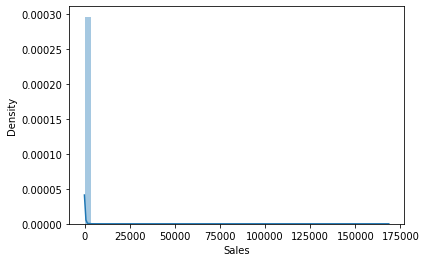

In [ ]:
sns.distplot(daily_data['Sales'])
plt.show()

In [ ]:
daily_data = daily_data[daily_data['Sales'] <	224.1228]

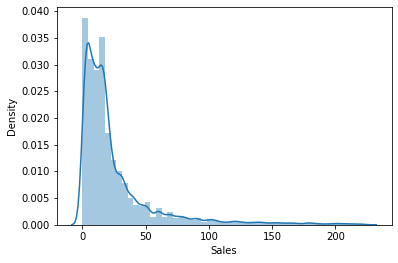

In [ ]:
sns.distplot(daily_data['Sales'])
plt.show()

In [ ]:
print("Skewness: {:.2f}".format(daily_data['Sales'].skew()))
print("Kurtosis: {:.2f}".format(daily_data['Sales'].kurt()))

Skewness: 2.86
Kurtosis: 9.59


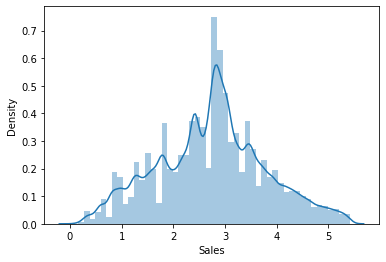

In [ ]:
daily_data['Sales'] = np.log1p(daily_data['Sales'])
sns.distplot(daily_data['Sales'])
plt.show()

In [ ]:
print("Skewness: {:.2f}".format(daily_data['Sales'].skew()))
print("Kurtosis: {:.2f}".format(daily_data['Sales'].kurt()))

Skewness: 0.04
Kurtosis: -0.28


In [ ]:
# back = np.expm1(df['Sales'])
# sns.distplot(back)
# plt.show()

# **Feature engineering**

In [ ]:
daily_data[['Quantity', 'UnitPrice', 'Sales']].describe()

,Quantity,UnitPrice,Sales
count,237583.000000,237583.000000,237583.000000
mean,16.563172,4.407188,2.742275
std,31.678964,6.154723,1.043288
min,1.000000,0.040000,0.058269
25%,3.000000,1.250000,2.043814
50%,8.000000,2.500000,2.772589
75%,18.000000,5.000000,3.430109
max,3206.000000,195.000000,5.416545


In [ ]:
bins_q = pd.IntervalIndex.from_tuples([(0, 3), (3, 8), (8, 18), (18, 3206)])
daily_data['QuantityRange'] = pd.cut(daily_data['Quantity'], bins=bins_q)
bins_p = pd.IntervalIndex.from_tuples([(0, 1.25), (1.25, 2.5), (2.5, 5.0), (5.0, 195)])
daily_data['PriceRange'] = pd.cut(daily_data['UnitPrice'], bins=bins_p)
daily_data.head()

,StockCode,Year,Quarter,Month,Week,Weekday,Dayofyear,Country_UK,Quantity,UnitPrice,Sales,QuantityRange,PriceRange
0,10002,2010,4,12,48,2,335,no_uk,48,0.85,3.732896,"(22, 3500]","(0.0, 1.25]"
1,10002,2010,4,12,48,2,335,uk,12,0.85,2.415914,"(8, 22]","(0.0, 1.25]"
2,10002,2010,4,12,48,4,337,uk,1,0.85,0.615186,"(0, 3]","(0.0, 1.25]"
3,10002,2010,4,12,48,6,339,uk,1,0.85,0.615186,"(0, 3]","(0.0, 1.25]"
4,10002,2010,4,12,49,0,340,uk,24,0.85,3.063391,"(22, 3500]","(0.0, 1.25]"


In [ ]:
from sklearn.preprocessing import LabelEncoder
daily_data['StockCode']=LabelEncoder().fit_transform(daily_data['StockCode']) 
df_data = pd.get_dummies(daily_data [['QuantityRange',	'PriceRange',	'Country_UK']],prefix=['qr','pr','dr'])
daily_data = daily_data.drop(['QuantityRange',	'PriceRange',	'Country_UK'], axis=1)
daily_data = pd.concat([daily_data ,df_data], axis=1)
daily_data.head()

,StockCode,Year,Quarter,Month,Week,Weekday,Dayofyear,Quantity,UnitPrice,Sales,"qr_(0, 3]","qr_(3, 8]","qr_(8, 22]","qr_(22, 3500]","pr_(0.0, 1.25]","pr_(1.25, 2.55]","pr_(2.55, 5.9]","pr_(5.9, 200.0]",dr_no_uk,dr_uk
0,0,2010,4,12,48,2,335,48,0.85,3.732896,0,0,0,1,1,0,0,0,1,0
1,0,2010,4,12,48,2,335,12,0.85,2.415914,0,0,1,0,1,0,0,0,0,1
2,0,2010,4,12,48,4,337,1,0.85,0.615186,1,0,0,0,1,0,0,0,0,1
3,0,2010,4,12,48,6,339,1,0.85,0.615186,1,0,0,0,1,0,0,0,0,1
4,0,2010,4,12,49,0,340,24,0.85,3.063391,0,0,0,1,1,0,0,0,0,1


# **Model Building**

**切分數據**

In [ ]:
y = daily_data['Sales']
X = daily_data.drop(columns=['Year', 'Quantity', 'UnitPrice', 'Sales'])
X.head()

,StockCode,Quarter,Month,Week,Weekday,Dayofyear,"qr_(0, 3]","qr_(3, 8]","qr_(8, 22]","qr_(22, 3500]","pr_(0.0, 1.25]","pr_(1.25, 2.55]","pr_(2.55, 5.9]","pr_(5.9, 200.0]",dr_no_uk,dr_uk
0,0,4,12,48,2,335,0,0,0,1,1,0,0,0,1,0
1,0,4,12,48,2,335,0,0,1,0,1,0,0,0,0,1
2,0,4,12,48,4,337,1,0,0,0,1,0,0,0,0,1
3,0,4,12,48,6,339,1,0,0,0,1,0,0,0,0,1
4,0,4,12,49,0,340,0,0,0,1,1,0,0,0,0,1


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
LR = LinearRegression()
LR.fit(X_train, y_train)
y_predict = LR.predict(X_test)
score = LR.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_predict)
mse = mean_absolute_error(y_test, y_predict)
rmse = np.sqrt(mean_squared_error(y_test, y_predict))
print('Score: ', score)
print('MAE: ', mae)
print('MSE: ', mse)
print('RMSE: ', rmse)

Score:  0.8025803029342108
MAE:  0.36113110932705617
MSE:  0.36113110932705617
RMSE:  0.46681917472952716


In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)
score = rf.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_predict)
mse = mean_absolute_error(y_test, y_predict)
rmse = np.sqrt(mean_squared_error(y_test, y_predict))
print('Score: ', score)
print('MAE: ', mae)
print('MSE: ', mse)
print('RMSE: ', rmse)



Score:  0.8875620316907815
MAE:  0.24405051083189083
MSE:  0.24405051083189083
RMSE:  0.35229780775393676


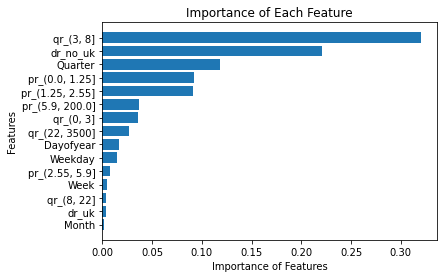

In [ ]:
# 變項重要程度
imp=rf.feature_importances_
names = X_train.columns[1:]
zip(imp,names)
imp, names= zip(*sorted(zip(imp,names)))
plt.barh(range(len(names)),imp,align='center')
plt.yticks(range(len(names)),names)
plt.xlabel('Importance of Features')
plt.ylabel('Features')
plt.title('Importance of Each Feature')
plt.show()

**Auto-Sklearn**

In [ ]:
# !pip install auto-sklearn

In [ ]:
import autosklearn.regression

autosklearn_regressor = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=3600,
    per_run_time_limit=360,
)

autosklearn_regressor.fit(X_train, y_train)

AutoSklearnRegressor(per_run_time_limit=360)

In [ ]:
print(autosklearn_regressor.sprint_statistics())

auto-sklearn results:
  Dataset name: 8bc6bfb4-e5fe-11ec-829f-0242ac1c0002
  Metric: r2
  Best validation score: 0.864488
  Number of target algorithm runs: 78
  Number of successful target algorithm runs: 39
  Number of crashed target algorithm runs: 10
  Number of target algorithms that exceeded the time limit: 4
  Number of target algorithms that exceeded the memory limit: 25



In [ ]:
print(autosklearn_regressor.leaderboard())

          rank  ensemble_weight                 type      cost    duration
model_id                                                                  
73           1             0.42    gradient_boosting  0.135512  101.241917
57           2             0.02    gradient_boosting  0.141772   20.929536
46           3             0.10    gradient_boosting  0.142063   27.878610
76           4             0.16    gradient_boosting  0.142722   43.652190
31           5             0.04    gradient_boosting  0.145567    5.611705
56           6             0.10    gradient_boosting  0.147510   62.440345
45           7             0.08    gradient_boosting  0.148146   31.844873
68           8             0.02    gradient_boosting  0.150940   97.988355
59           9             0.02    gradient_boosting  0.153352   62.149008
10          10             0.04  k_nearest_neighbors  0.232147   51.080989


In [ ]:
print(autosklearn_regressor.show_models())

{73: {'model_id': 73, 'rank': 1, 'cost': 0.1355123844843804, 'ensemble_weight': 0.42, 'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7f05a0df0ad0>, 'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7f05a13de4d0>, 'regressor': <autosklearn.pipeline.components.regression.RegressorChoice object at 0x7f05a1073410>, 'sklearn_regressor': HistGradientBoostingRegressor(l2_regularization=0.019103475435292835,
                              learning_rate=0.03881136706904198, max_iter=512,
                              max_leaf_nodes=738, min_samples_leaf=13,
                              n_iter_no_change=4, random_state=1,
                              validation_fraction=None, warm_start=True)}, 57: {'model_id': 57, 'rank': 2, 'cost': 0.14177246524544385, 'ensemble_weight': 0.02, 'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorCh

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(
      learning_rate=0.03881136706904198,                              
      max_leaf_nodes=738, 
      min_samples_leaf=13,                              
      n_iter_no_change=4, 
      random_state=1,)
gbr.fit(X_train, y_train)
y_predict = gbr.predict(X_test)

score = gbr.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_predict)
mse = mean_absolute_error(y_test, y_predict)
rmse = np.sqrt(mean_squared_error(y_test, y_predict))
print('Score: ', score)
print('MAE: ', mae)
print('MSE: ', mse)
print('RMSE: ', rmse)

Score:  0.8023946372477097
MAE:  0.35798807421365725
MSE:  0.35798807421365725
RMSE:  0.4670386359469613


**XGBoost**

In [ ]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]

In [ ]:
from xgboost import XGBRegressor
xgbr = XGBRegressor(
      random_state =42,
      learning_rate = 0.2,
      max_iter = 500,
      max_leaf_nodes = 1000, 
      min_samples_leaf= 10,
      objective = "reg:squarederror")
xgbr.fit(X_train, y_train)
y_predict = xgbr.predict(X_test)

score = xgbr.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_predict)
mse = mean_absolute_error(y_test, y_predict)
rmse = np.sqrt(mean_squared_error(y_test, y_predict))
print('Score: ', score)
print('MAE: ', mae)
print('MSE: ', mse)
print('RMSE: ', rmse)

Score:  0.8293443873127537
MAE:  0.33261922219241447
MSE:  0.33261922219241447
RMSE:  0.43402398897496813


**RandomForest**


In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)
score = rf.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_predict)
mse = mean_absolute_error(y_test, y_predict)
rmse = np.sqrt(mean_squared_error(y_test, y_predict))
print('Score: ', score)
print('MAE: ', mae)
print('MSE: ', mse)
print('RMSE: ', rmse)

Score:  0.887292757556081
MAE:  0.2442050717774287
MSE:  0.2442050717774287
RMSE:  0.35271940892463005


In [ ]:
rf = RandomForestRegressor(
    n_estimators=1000, 
    max_depth=20,
    max_features=10,
    random_state=42)
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)
score = rf.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_predict)
mse = mean_absolute_error(y_test, y_predict)
rmse = np.sqrt(mean_squared_error(y_test, y_predict))
print('Score: ', score)
print('MAE: ', mae)
print('MSE: ', mse)
print('RMSE: ', rmse)

Score:  0.8692666046099772
MAE:  0.28133265431979715
MSE:  0.28133265431979715
RMSE:  0.3798802510210474
